<img src="https://avatars.githubusercontent.com/u/74911464?s=200&v=4"
     alt="OpenEO Platform logo"
     style="float: left; margin-right: 10px;" />
## openEO Platform: Seasonal Soil Moisture over Austria

In [1]:
from eo_utils import * 

In [16]:
conn = openeo.connect("https://openeo-dev.eodc.eu/v1.0")
conn.authenticate_oidc(provider_id="egi")

Authenticated using refresh token.


<Connection to 'https://openeo-dev.eodc.eu/v1.0' with BearerAuth>

In [17]:
center = [47.657741, 13.483181]
zoom = 7.3

eoMap = openeoMap(center,zoom)
addS2Tiles(eoMap)
eoMap.map

Map(center=[47.657741, 13.483181], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

In [19]:
bbox = eoMap.getBbox()
print('west',bbox[0],'\neast',bbox[2],'\nsouth',bbox[1],'\nnorth',bbox[3])

west 8.107910156250002 
east 18.8525390625 
south 46.15700496290803 
north 49.11702904077932


### Product Selection

In [21]:
collection      = 'CGLS_SSM_1KM'

spatial_extent  = {'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3],'crs':'EPSG:4326'}
temporal_extent = ["2020-01-01", "2020-12-31"] 

bands           = ["B01"] 

data = conn.load_collection(collection, spatial_extent=spatial_extent,bands=bands,temporal_extent=temporal_extent)

### Process definition

In [22]:
data_aggregate_mean = data.aggregate_temporal_period(reducer="mean", period="season", dimension="t")
data_saved = data_aggregate_mean.save_result(format="NetCDF")

In [23]:
data_saved.graph

{'loadcollection1': {'process_id': 'load_collection',
  'arguments': {'bands': ['B01'],
   'id': 'CGLS_SSM_1KM',
   'spatial_extent': {'west': 8.107910156250002,
    'east': 18.8525390625,
    'south': 46.15700496290803,
    'north': 49.11702904077932,
    'crs': 'EPSG:4326'},
   'temporal_extent': ['2020-01-01', '2020-12-31']}},
 'aggregatetemporalperiod1': {'process_id': 'aggregate_temporal_period',
  'arguments': {'data': {'from_node': 'loadcollection1'},
   'dimension': 't',
   'period': 'season',
   'reducer': {'process_graph': {'mean1': {'process_id': 'mean',
      'arguments': {'data': {'from_parameter': 'data'}},
      'result': True}}}}},
 'saveresult1': {'process_id': 'save_result',
  'arguments': {'data': {'from_node': 'aggregatetemporalperiod1'},
   'format': 'NetCDF',
   'options': {}},
  'result': True}}

### Job creation & Status check

In [24]:
job_ard = conn.create_job(data_saved.graph)
job_id_ard = job_ard.job_id
if job_id_ard:
    print("Batch job created with id: ",job_id_ard)
    job_ard.start_job()
else:
    print("Error! Job ID is None")

Batch job created with id:  jb-68cc76f5-c0e4-4c10-a73a-dcab127d6f82


In [30]:
job_ard = conn.job(job_id_ard)
job_description_ard = job_ard.describe_job()
print("Batch job with id: ",job_id_ard, ' is ',job_description_ard['status'])

Batch job with id:  jb-68cc76f5-c0e4-4c10-a73a-dcab127d6f82  is  finished


### Results Download

In [31]:
results_ard = job_ard.get_results()
metadata_ard = results_ard.get_metadata()
results = results_ard.download_files("./demo")

In [32]:
output_data = xr.open_mfdataset(results[1:])
output_data

<xarray.Dataset>
Dimensions:      (season: 4, y: 442, x: 846)
Coordinates:
  * y            (y) float64 1.816e+06 1.814e+06 ... 1.376e+06 1.374e+06
  * x            (x) float64 4.616e+06 4.618e+06 ... 5.46e+06 5.462e+06
    spatial_ref  int32 0
  * season       (season) object 'DJF' 'JJA' 'MAM' 'SON'
    t            datetime64[ns] 2022-05-12T09:58:11.763715
Data variables:
    B01          (season, y, x) float64 dask.array<chunksize=(4, 16, 84), meta=np.ndarray>
Attributes:
    nodata:             -9999
    crs:                PROJCRS["Azimuthal_Equidistant",BASEGEOGCRS["WGS 84",...
    datetime_from_dim:  2022-05-12 09:58:11.766457

### Results Plotting

In [33]:
winter = output_data.B01[0]
summer = output_data.B01[1]

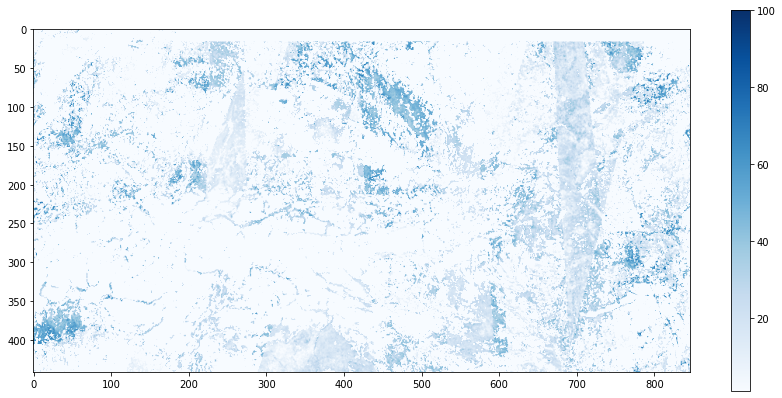

In [43]:
plt.figure(figsize=(50,7))
plt.subplot(1,3,1)
plt.imshow(winter, cmap = "Blues", vmin=1, vmax=100)   
plt.colorbar()

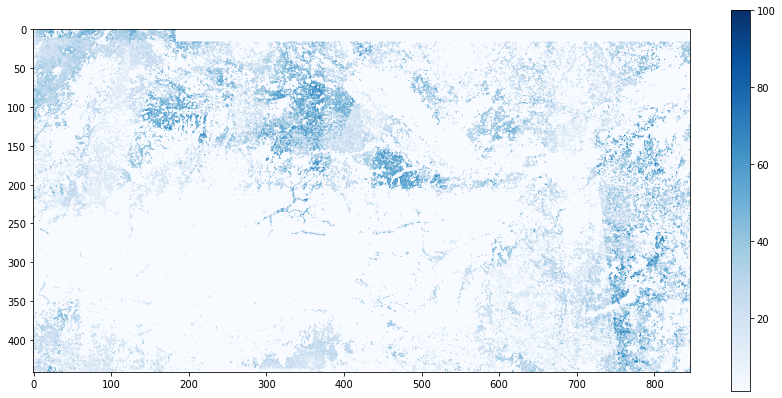

In [38]:
plt.figure(figsize=(50,7))
plt.subplot(1,3,1)
plt.imshow(summer, cmap = "Blues", vmin=1, vmax=100)   
plt.colorbar()

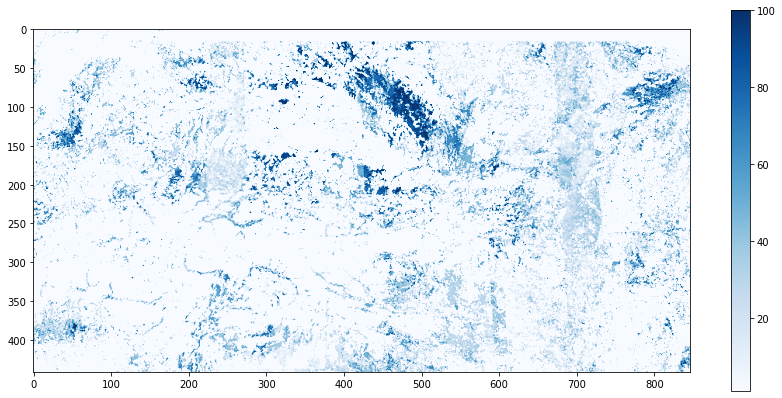

In [40]:
plt.figure(figsize=(50,7))
plt.subplot(1,3,1)
plt.imshow((winter - summer), cmap = "Blues", vmin=1, vmax=100)   
plt.colorbar()